In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..')

from familiarity.commons import get_layers_of_interest
from familiarity.familiarization import get_results 
from familiarity.config import DATA_DIR

net='vgg16'
dataset='lfw-deepfunneled'
data_dir=os.path.join(DATA_DIR, 'fine_tuning')
save_dir='../figures'
start_fracs = [0.01, 0.1, 1.0]
fbf_dict = dict(start_epochs=None,
                incr_frac=None,
                incr_epochs=None,
                no_grow_data=True)
_, layers = get_layers_of_interest(net)

# Understanding the role of face training set size 
We know that prior experience with faces is important for unfamiliar and familiar face verification, but we do not yet know how much experience is necessary for each task. The goal here is to assess the role of face training set size in verification of unfamiliar and familiar faces. 

Different fractions of identities in the VGGFace2 database were used in pre-training VGG-16. Verification experiments were then performed on novel identities in LFW.

In [2]:
results = dict(layer=[], train_fraction=[], familiar=[], dprime=[])
for start_frac in start_fracs:
    fbf_dict['start_frac'] = start_frac
    if start_frac == 1.0:
        use_fbf_dict = None
        use_net = 'vgg16_train-vggface2'
    else:
        use_fbf_dict = fbf_dict
        use_net = net
    for layer in layers:
        for epoch in [0,-1]:
            use_epoch = epoch if layer in ['IT', 'decoder', 'class-prob', 'fc6', 'fc7', 'prob'] else 0
            try:
                res = get_results('verification-dprime', use_net, dataset, use_epoch, layer,
                                  id_thresh=18,
                                  n_val=10,
                                  data_dir=data_dir,
                                  fbf_dict=use_fbf_dict)
                results['layer'].append(layer)
                results['familiar'].append(epoch == -1)
                results['train_fraction'].append(start_frac)
                results['dprime'].append(res)
            except Exception as e: 
#                 print(e)
                pass
results = pd.DataFrame(results)

## penultimate and output layers

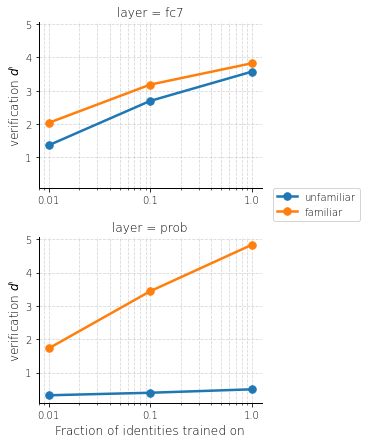

In [3]:
fig, axs = plt.subplots(2,1, figsize=(4,7), sharey=True)
axs[0].plot([0.01,0.1,1.0], results.dprime[
    np.logical_and(np.equal(results.layer, 'fc7'), np.equal(results.familiar, False))
    ], linewidth=2.5, markersize=15, marker='.', label='unfamiliar'
)
axs[0].plot([0.01,0.1,1.0], results.dprime[
    np.logical_and(np.equal(results.layer, 'fc7'), np.equal(results.familiar, True))
    ], linewidth=2.5, markersize=15, marker='.', label='familiar'
)
axs[0].set_xscale('log')
axs[1].plot([0.01,0.1,1.0], results.dprime[
    np.logical_and(np.equal(results.layer, 'prob'), np.equal(results.familiar, False))
    ], linewidth=2.5, markersize=15, marker='.', label='unfamiliar'
)
axs[1].plot([0.01,0.1,1.0], results.dprime[
    np.logical_and(np.equal(results.layer, 'prob'), np.equal(results.familiar, True))
    ], linewidth=2.5, markersize=15, marker='.', label='familiar'
)
axs[0].set_title('layer = fc7')
axs[0].set_ylabel(r"verification $d$'")
# axs[0].set_xlabel('Fraction of identities trained on')
axs[0].set_xticks([0.01,0.1,1.0])
axs[0].set_xticklabels(['0.01','0.1','1.0'])
plt.legend(bbox_to_anchor=(1.05, 1.3),loc=2, borderaxespad=0.)
plt.xscale('log')
axs[1].set_title('layer = prob')
axs[1].set_xlabel('Fraction of identities trained on')
axs[1].set_ylabel(r"verification $d$'")
axs[1].set_xticks([0.01,0.1,1.0])
axs[1].set_xticklabels(['0.01','0.1','1.0'])
plt.subplots_adjust(hspace=.3)
plt.savefig(f'{save_dir}/fbf/{net}_verify-{dataset}_dual_plots.png', bbox_inches='tight', dpi=150)
plt.show()

## penultimate and output layers (alternative plot)

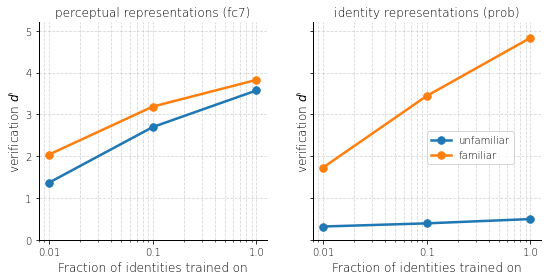

In [4]:
fig, axs = plt.subplots(1,2, figsize=(9,4), sharey=True)
axs[0].plot([0.01,0.1,1.0], results.dprime[
    np.logical_and(np.equal(results.layer, 'fc7'), np.equal(results.familiar, False))
    ], linewidth=2.5, markersize=15, marker='.', label='unfamiliar'
)
axs[0].plot([0.01,0.1,1.0], results.dprime[
    np.logical_and(np.equal(results.layer, 'fc7'), np.equal(results.familiar, True))
    ], linewidth=2.5, markersize=15, marker='.', label='familiar'
)
axs[0].set_xscale('log')
axs[1].plot([0.01,0.1,1.0], results.dprime[
    np.logical_and(np.equal(results.layer, 'prob'), np.equal(results.familiar, False))
    ], linewidth=2.5, markersize=15, marker='.', label='unfamiliar'
)
axs[1].plot([0.01,0.1,1.0], results.dprime[
    np.logical_and(np.equal(results.layer, 'prob'), np.equal(results.familiar, True))
    ], linewidth=2.5, markersize=15, marker='.', label='familiar'
)
axs[0].set_ylabel(r"verification $d$'")
axs[0].set_xlabel('Fraction of identities trained on')
axs[0].set_xticks([0.01,0.1,1.0])
axs[0].set_ylim([0, 5.2])
axs[0].set_xticklabels(['0.01','0.1','1.0'])
axs[0].set_title('perceptual representations (fc7)')
plt.legend(bbox_to_anchor=(.5, .5),loc=2, borderaxespad=0.)
plt.xscale('log')
axs[1].set_xlabel('Fraction of identities trained on')
axs[1].set_ylabel(r"verification $d$'")
axs[1].set_xticks([0.01,0.1,1.0])
axs[1].set_xticklabels(['0.01','0.1','1.0'])
axs[1].set_title('identity representations (prob)')
# plt.subplots_adjust(hspace=.3)
plt.savefig(f'{save_dir}/fbf/{net}_verify-{dataset}_dual_plots_horiz.png', bbox_inches='tight', dpi=150)
plt.show()

## All layers

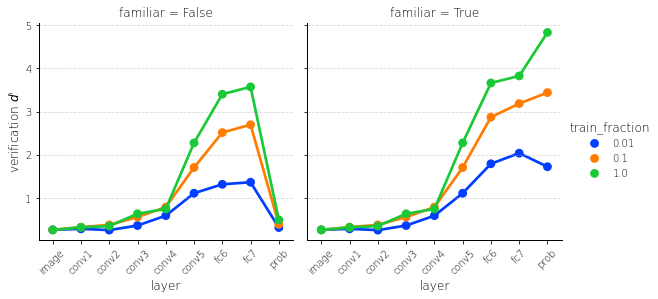

In [5]:
g = sns.catplot('layer', 'dprime', hue='train_fraction', palette='bright', col='familiar', split=True, kind='point',
              data=results, ylabel=r"verification $d$'", height=4)
g.set_xticklabels(rotation=45)
g.set_axis_labels(y_var=r"verification $d$'")
plt.savefig(f'{save_dir}/fbf/{net}_verify-{dataset}_dual-all-layer-plots.png', bbox_inches='tight', dpi=150)
plt.show()

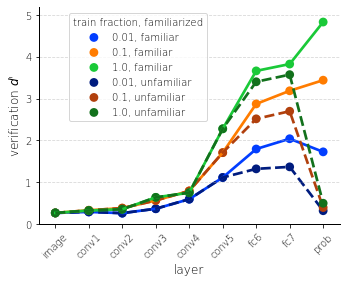

In [6]:
n_fracs = len(np.unique(results.train_fraction))
fig, ax = plt.subplots(figsize=(5.4,4))
sns.pointplot('layer', 'dprime', hue='train_fraction', ax=ax, palette='bright',
              data=results[np.logical_and(1,results.familiar==True)])
sns.pointplot('layer', 'dprime', hue='train_fraction', ax=ax, linestyles='--', palette='dark',
              data=results[np.logical_and(1,results.familiar==False)])
handles, labels = ax.get_legend_handles_labels() 
labels = [label + ', familiar' if ii<n_fracs else label+', unfamiliar' for ii, label in enumerate(labels)]
l = plt.legend(handles, labels, bbox_to_anchor=(.1, 0.97), title='train fraction, familiarized',loc=2, borderaxespad=0.)
plt.ylabel(r"verification $d$'")
plt.xticks(rotation=45)
plt.ylim([0, 5.2])
fig.savefig(f'{save_dir}/fbf/{net}_verify-{dataset}_all-layer-plot.png', bbox_inches='tight', dpi=150)
plt.show()